# 1. Text preprocessing

1.1. Getting data

In [1]:
with open('анна каренина.txt', 'r') as f:
  X = f.read()

X

'Все счастливые семьи похожи друг на друга, каждая несчастливая семья несчастлива по-своему.\n   Все смешалось в доме Облонских. Жена узнала, что муж был в связи с бывшею в их доме француженкою-гувернанткой, и объявила мужу, что не может жить с ним в одном доме. Положение это продолжалось уже третий день и мучительно чувствовалось и самими супругами, и всеми членами семьи, и домочадцами. Все члены семьи и домочадцы чувствовали, что нет смысла в их сожительстве и что на каждом постоялом дворе случайно сошедшиеся люди более связаны между собой, чем они, члены семьи и домочадцы Облонских. Жена не выходила из своих комнат, мужа третий день не было дома. Дети бегали по всему дому, как потерянные; англичанка поссорилась с экономкой и написала записку приятельнице, прося приискать ей новое место; повар ушел еще вчера со двора, во время обеда; черная кухарка и кучер просили расчета.\n   На третий день после ссоры князь Степан Аркадьич Облонский -- Стива, как его звали в свете, -- в обычный час

1.2 Normalizing text

In [2]:
import nltk
import re

X = re.sub(r'\t+|\n+|\xa0—|\ufeff', ' ', X)
nltk.download('punkt')
X = nltk.tokenize.sent_tokenize(X)
#X = [sent for sent in X if not re.match('ГЛАВА [XVI]{1,4}', sent)],
print(len(X))
X

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


4350


['Все счастливые семьи похожи друг на друга, каждая несчастливая семья несчастлива по-своему.',
 'Все смешалось в доме Облонских.',
 'Жена узнала, что муж был в связи с бывшею в их доме француженкою-гувернанткой, и объявила мужу, что не может жить с ним в одном доме.',
 'Положение это продолжалось уже третий день и мучительно чувствовалось и самими супругами, и всеми членами семьи, и домочадцами.',
 'Все члены семьи и домочадцы чувствовали, что нет смысла в их сожительстве и что на каждом постоялом дворе случайно сошедшиеся люди более связаны между собой, чем они, члены семьи и домочадцы Облонских.',
 'Жена не выходила из своих комнат, мужа третий день не было дома.',
 'Дети бегали по всему дому, как потерянные; англичанка поссорилась с экономкой и написала записку приятельнице, прося приискать ей новое место; повар ушел еще вчера со двора, во время обеда; черная кухарка и кучер просили расчета.',
 'На третий день после ссоры князь Степан Аркадьич Облонский -- Стива, как его звали в св

1.3 Vectorization

In [3]:
nltk.download('stopwords')
from nltk.corpus import stopwords
!python -m spacy download ru_core_news_md
import spacy
nlp = spacy.load('ru_core_news_md')
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def tokenizer(sent):
  return [token.lemma_ for token in nlp(sent) if token.is_alpha]

stop_words = stopwords.words('russian')
vectorizer = CountVectorizer(binary=True,
                             stop_words = stop_words,
                             tokenizer = tokenizer)
data = vectorizer.fit_transform(X)
data = pd.DataFrame(data.todense(),
                    columns=vectorizer.get_feature_names_out())
data.info()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2022-11-13 19:04:30.598366: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41.9 MB 71 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_md')


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['весь', 'мочь', 'ничто', 'свой', 'хороший', 'это'] not in stop_words.
  % sorted(inconsistent)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4350 entries, 0 to 4349
Columns: 6820 entries, a to ящик
dtypes: int64(6820)
memory usage: 226.3 MB


# 2. Clustering tokens

2.1 Agglomeration model fitting

In [4]:
from sklearn.cluster import FeatureAgglomeration

model = FeatureAgglomeration(n_clusters = None, distance_threshold = 0.1)
model.fit(data)
max_dist = max(model.distances_)

# максимальные расстояния между точками
max_dist

33.89973850942072

2.2 Hyperparameter search

In [5]:
import numpy as np

dims = []
step = max_dist/50
for i in np.arange(step, max_dist, step):
  model = FeatureAgglomeration(n_clusters = None, distance_threshold = i)
  clusters = model.fit_transform(data)
  dims.append({'param': round(i, 3),
               'dim': clusters.shape[1]})
  
dims[:5]

[{'param': 0.678, 'dim': 4862},
 {'param': 1.356, 'dim': 3991},
 {'param': 2.034, 'dim': 2581},
 {'param': 2.712, 'dim': 1795},
 {'param': 3.39, 'dim': 1246}]

2.3 Calculating differences

In [6]:
last = len(dims) - 1
dims[last]['diff'] = 0
for i, dim in enumerate(dims):
  if i == last:
    break
  dim['diff'] = dim['dim'] - dims[i+1]['dim']
dims[:5]

[{'param': 0.678, 'dim': 4862, 'diff': 871},
 {'param': 1.356, 'dim': 3991, 'diff': 1410},
 {'param': 2.034, 'dim': 2581, 'diff': 786},
 {'param': 2.712, 'dim': 1795, 'diff': 549},
 {'param': 3.39, 'dim': 1246, 'diff': 422}]

2.4 Visualizing

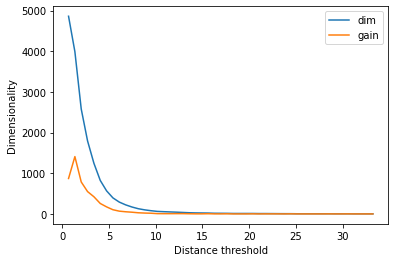

In [7]:
from matplotlib import pyplot as plt

param_list = [x['param'] for x in dims]
dim_list = [x['dim'] for x in dims]
diff_list = [x['diff'] for x in dims]

fig = plt.figure()
ax = fig.add_subplot()
ax.set_ylabel('Dimensionality')
ax.set_xlabel('Distance threshold')
plt.plot(param_list, dim_list, label='dim')
plt.plot(param_list, diff_list, label='gain')
ax.legend()
plt.show()

2.5 Getting optimal cut

In [8]:
dims_sorted = sorted(dims, key=lambda x: x['diff'], reverse=True)
threshold = dims_sorted[0]['param']

model = FeatureAgglomeration(n_clusters = None,
                             distance_threshold = threshold,
                             pooling_func = np.min)
data_clustered = model.fit_transform(data)
data_clustered = pd.DataFrame(data_clustered)
labels = model.labels_

data_clustered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4350 entries, 0 to 4349
Columns: 3991 entries, 0 to 3990
dtypes: int64(3991)
memory usage: 132.5 MB


# 3. Relation extraction

3.1 Getting itemsets

In [9]:
from mlxtend.frequent_patterns import apriori

min_support = 2/len(data)
itemsets = apriori(data_clustered,
                   min_support = min_support,
                   max_len = 2)
itemsets

,support,itemsets
0,0.000460,(111)
1,0.000460,(146)
2,0.000460,(162)
3,0.000460,(213)
4,0.000460,(216)
...,...,...
17044,0.000460,"(3974, 3775)"
17045,0.001149,"(3839, 3807)"
17046,0.001609,"(3871, 3839)"
17047,0.000920,"(3976, 3839)"


3.2 Searching

In [10]:
from mlxtend.frequent_patterns import association_rules

rules = association_rules(itemsets, min_threshold = min_support)
rules['antecedents'] = rules['antecedents'].apply(lambda x: list(x)[0])
rules['consequents'] = rules['consequents'].apply(lambda x: list(x)[0])

rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,2099,111,0.044138,0.000460,0.000460,0.010417,22.656250,0.000439,1.010062
1,111,2099,0.000460,0.044138,0.000460,1.000000,22.656250,0.000439,inf
2,2131,111,0.034943,0.000460,0.000460,0.013158,28.618421,0.000444,1.012867
3,111,2131,0.000460,0.034943,0.000460,1.000000,28.618421,0.000444,inf
4,2388,111,0.002069,0.000460,0.000460,0.222222,483.333333,0.000459,1.285123
...,...,...,...,...,...,...,...,...,...
29667,3839,3871,0.035862,0.008506,0.001609,0.044872,5.275468,0.001304,1.038075
29668,3976,3839,0.005287,0.035862,0.000920,0.173913,4.849498,0.000730,1.167114
29669,3839,3976,0.035862,0.005287,0.000920,0.025641,4.849498,0.000730,1.020889
29670,3895,3871,0.001149,0.008506,0.000460,0.400000,47.027027,0.000450,1.652490


3.3 Searching for inclusions

In [11]:
incls = rules[rules['confidence'] == 1]
incls = incls[['antecedents', 'consequents']]
# если в предложении есть токен-antecedent, то есть и токен-consequent 100%

incls

,antecedents,consequents
1,111,2099
3,111,2131
5,111,2388
7,111,2966
9,111,3007
...,...,...
29077,3693,3400
29079,3403,3465
29092,3414,3599
29129,3428,3504


# 4. Knowledge Graph

4.1 Creating ontology

In [12]:
!pip install Cython
!pip install owlready2
from owlready2 import *
import types

onto = get_ontology('http://onto.owl')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.5 MB 2.7 MB/s 
  Created wheel for owlready2: filename=Owlready2-0.39-cp37-cp37m-linux_x86_64.whl size=22132068 sha256=93028bdc1e2c39e7d2acdc6dac7cbb436454577226b60da1bf3c78b0a0c1be67
  Stored in directory: /root/.cache/pip/wheels/c9/5b/fc/da1e42a17f22cd62bfb170f847a3fb541a7f628858ad3595ec
Successfully built owlready2


4.2 Creating individuals for sentences

In [13]:
with onto:
  onto_sent = types.new_class('Sentence', (Thing,))
  types.new_class('hasText', (DataProperty, FunctionalProperty))
  for i, sent in enumerate(X):
    sent_inst = onto_sent(f'sentence_{i}')
    sent_inst.hasText = sent
    
onto.save('onto.owl')

4.3 Creating classes for tokens

In [14]:
with onto:
  onto_token = types.new_class('Token', (Thing,))
  for i, token in enumerate(data.columns):
    token_inst = onto_token(f'token_{i}')
    token_inst.label = token

onto.save('onto.owl')

4.4 Linking sentences with tokens

In [15]:
with onto:
  hasToken = types.new_class('hasToken', (ObjectProperty,))
  for i, row in data.iterrows():
    sent_inst = onto[f'sentence_{i}']
    for j, token in enumerate(data.columns):
      if row[token] == 1:
        token_inst = onto[f'token_{j}']
        sent_inst.hasToken.append(token_inst)

onto.save('onto.owl')

4.5 Creating clusters

In [16]:
with onto:
  onto_clust = types.new_class('Cluster', (Thing,))
  for label in set(labels):
    clust_cl = types.new_class(f'Cluster_{label}', (onto_clust,))

onto.save('onto.owl')

4.6 Linking clusters with tokens

In [17]:
with onto:
  for i, label in enumerate(labels):
    clust_cl = onto[f'Cluster_{label}']
    token_inst = onto[f'token_{i}']
    clust_cl.equivalent_to.append(hasToken.value(token_inst))
onto.save('onto.owl')

4.7 Setting inclusions

In [18]:
with onto:
  for index, row in incls.iterrows():
    ant = row['antecedents']
    con = row['consequents']
    ant_cl = onto[f'Cluster_{ant}']
    con_cl = onto[f'Cluster_{con}']
    reverse = incls[(incls['antecedents'] == con) & (incls['consequents'] == ant)]
    if reverse.empty:
      # SubclassOf
      ant_cl.is_a.append(con_cl)
    else:
      ant_cl.equivalent_to.append(con_cl)
      
onto.save('onto.owl')

In [19]:
# onto = get_ontology("onto.owl").load()

4.8 Running reasoner

In [20]:
with onto:
  sync_reasoner_pellet()

onto.save('onto_reasoned.owl', format='ntriples')

* Owlready2 * Running Pellet...
    java -Xmx2000M -cp /usr/local/lib/python3.7/dist-packages/owlready2/pellet/antlr-3.2.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/slf4j-log4j12-1.6.4.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/antlr-runtime-3.2.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/log4j-1.2.16.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/xml-apis-1.4.01.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/jcl-over-slf4j-1.6.4.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/jgrapht-jdk1.5.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/commons-codec-1.6.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/pellet-2.3.1.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/aterm-java-1.6.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/httpcore-4.2.2.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/jena-arq-2.10.0.jar:/usr/local/lib/python3.7/dist-packa